## Tutorial - Measuring sensitivity of hyperparameter choice

This tutorial demonstrates how one can use the library to measure to what extent the outcome of evaluation is sensitive to the choice of hyperparameters e.g., choice of baseline value to mask an image with, patch sizes or number of runs. We use a LeNet model and CIFAR-10 dataset to showcase the library's functionality and test the Faithfulness Correlation by Bhatt et al., 2020.



In [1]:
# Mount Google Drive. #remove
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111  -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import cv2
import glob
import pathlib
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/torch_stable.html


### Load CIFAR10 dataset.

In [72]:
# Load datasets and make loaders.
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.CIFAR10(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=12, pin_memory=True)

# Specify class labels.
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Files already downloaded and verified
Files already downloaded and verified


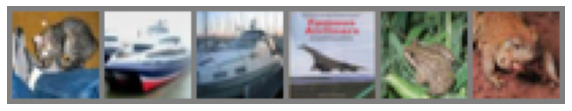

In [73]:
def plot_images(images):
    """Plot some images."""
    fig = plt.figure(figsize=(10, 10))
    img = images / 2 + 0.5   
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Plot image examples!
images, labels = iter(test_loader).next()
imshow(torchvision.utils.make_grid(images[:6, :, :, :]))

### Train a LeNet model.

(or any other model of choice). Network architecture and training procedure is partly copied from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py.

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(3, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.fc_1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = torch.nn.Linear(120, 84)
        self.fc_3 = torch.nn.Linear(84, 10)
        self.relu_1 = torch.nn.ReLU()
        self.relu_2 = torch.nn.ReLU()
        self.relu_3 = torch.nn.ReLU()
        self.relu_4 = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x


# Load model architecture.
model = Net()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: Net(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (relu_1): ReLU()
  (relu_2): ReLU()
  (relu_3): ReLU()
  (relu_4): ReLU()
)



In [47]:
def train_model(model, 
                train_data: torchvision.datasets,
                test_data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # Evaluate model!
        if evaluate:
            predictions, labels = evaluate_model(model, test_data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
        
        print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}% and CE loss {loss.item():.2f}")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [50]:
path_model_weights = "drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/cifar10"
"""
if pathlib.Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
    
else:
"""     
# Train and evaluate model.
model = train_model(model=model.to(device),
                    train_data=train_loader,
                    test_data=test_loader,
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                    evaluate=True)

# Save model.
torch.save(model.state_dict(), path_model_weights)

# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_loader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Epoch 1/20 - test accuracy: 59.83% and CE loss 1.20
Epoch 2/20 - test accuracy: 60.25% and CE loss 0.78
Epoch 3/20 - test accuracy: 60.82% and CE loss 0.69
Epoch 4/20 - test accuracy: 61.45% and CE loss 0.46
Epoch 5/20 - test accuracy: 61.07% and CE loss 0.78
Epoch 6/20 - test accuracy: 61.30% and CE loss 0.53
Epoch 7/20 - test accuracy: 60.60% and CE loss 0.57
Epoch 8/20 - test accuracy: 61.54% and CE loss 0.68
Epoch 9/20 - test accuracy: 59.04% and CE loss 0.67
Epoch 10/20 - test accuracy: 59.60% and CE loss 0.63
Epoch 11/20 - test accuracy: 60.29% and CE loss 0.52
Epoch 12/20 - test accuracy: 59.57% and CE loss 0.29
Epoch 13/20 - test accuracy: 60.27% and CE loss 0.46
Epoch 14/20 - test accuracy: 60.31% and CE loss 0.58
Epoch 15/20 - test accuracy: 59.90% and CE loss 0.59
Epoch 16/20 - test accuracy: 59.98% and CE loss 0.46
Epoch 17/20 - test accuracy: 59.47% and CE loss 0.62
Epoch 18/20 - test accuracy: 59.35% and CE loss 0.40
Epoch 19/20 - test accuracy: 59.98% and CE loss 0.46
Ep

### Load gradient-based attributions.

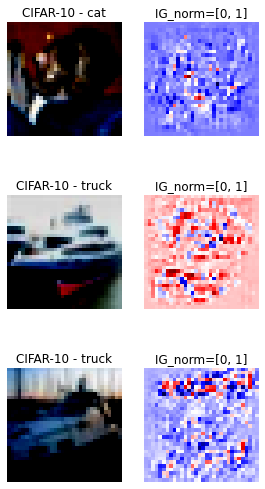

In [58]:
# Load attributions and plot them. 
a_batch = quantus.explain(model, 
                          x_batch, 
                          y_batch, 
                          method="IntegratedGradients",
                          **{"normalize": True})

# Plot examplary inputs!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*1.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow(np.moveaxis(np.clip(x_batch[i].cpu().numpy(), 0, 1), 0, -1), 
                   vmin=0.0, vmax=1.0)
    axes[i, 0].title.set_text(f"CIFAR-10 - {classes[y_batch[i].item()]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(a_batch[i], cmap="seismic")
    axes[i, 1].title.set_text(f"IG_norm=[0, 1]")
    axes[i, 1].axis("off")
plt.show()

### Meaure sensitivity of hyperparameter choice.

We want to understand how sensitive the evaluation outome of Faithfulness Correlation (Bhatt et al., 2020) is from its hyperparameters.

In [74]:
# Let's list the default parameters of the metric.
metric = quantus.FaithfulnessCorrelation()
metric.list_hyperparameters

{'abs': True,
 'default_plot_func': typing.Callable,
 'normalize': True,
 'normalize_func': <function quantus.helpers.normalize_func.normalize_by_max>,
 'nr_runs': 100,
 'perturb_baseline': 'black',
 'perturb_func': <function quantus.helpers.perturb_func.baseline_replacement_by_indices>,
 'similarity_func': <function quantus.helpers.similar_func.correlation_pearson>,
 'subset_size': 224,
 'text_warning': "\nThe Faithfulness correlation metric is known to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'. Go over and select each hyperparameter of the SelectivityN metric carefully to avoid misinterpretation of scores. To view all relevant hyperparameters call .list_hyperparameters method. For further reading, please see [CITATION].\n"}

In [75]:
# Define some parameter settings to evaluate.
baseline_strategies = ["mean", "random", "uniform", "black", "white"]
subset_sizes = np.arange(2, 128, 4)

# Recompute some Saliency explanations.
a_batch = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()

# Metric class expects numpy arrays.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

In [76]:
# Reinitalise the metric and then do a model call (in a one-liner!) while including the different tunable parameters.
results = {
    s: {b: np.mean(quantus.FaithfulnessCorrelation({'abs': True,
                                                    'normalize': True,
                                                    'normalize_func': quantus.normalize_by_max,
                                                    'nr_runs': 100,
                                                    'perturb_baseline': b,
                                                    'perturb_func': quantus.baseline_replacement_by_indices,
                                                    'similarity_func': quantus.correlation_pearson,
                                                    'subset_size': s})(model=model.cuda(), 
                                                                        x_batch=x_batch, 
                                                                        y_batch=y_batch,
                                                                        a_batch=a_batch,
                                                                        **{"device": device}))
    for b in baseline_strategies}
    for s in subset_sizes
}

In [77]:
# Summarise in a dataframe.      
df = pd.DataFrame(results)
df

,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30
mean,0.029941,0.091219,0.045790,-0.016732,0.084203,0.051852,-0.002768,-0.031535,0.018353,0.000879,-0.010202,0.028825,0.013745,0.047179,0.030339
random,-0.007940,0.014237,0.007557,0.012165,-0.005679,0.057701,0.041762,0.031326,0.022127,0.037124,0.069876,0.072030,0.029547,0.035689,0.003652
uniform,0.046728,0.011959,0.035829,-0.025395,-0.013098,0.001570,0.016860,-0.007148,0.001548,0.020048,-0.008450,0.040043,-0.001847,0.031999,0.016593
black,-0.009306,0.034219,0.083214,0.053674,-0.014455,0.060783,0.022171,0.021202,0.006349,0.069419,-0.015048,0.039894,0.057669,0.050193,-0.004504
white,0.031690,-0.000895,0.004334,0.034904,0.001097,0.045919,0.033168,0.043292,0.053713,0.068807,0.034331,0.071040,0.077408,0.036913,-0.019897


In [78]:
# Inspect the standard deviation of faithfulness scores - when it comes to baselines.
print(f"Standard deviation: {df.std(axis=1).mean():.2f}\n{df.std(axis=1)}")

Standard deviation: 0.03
mean       0.035154
random     0.025115
uniform    0.021182
black      0.032315
white      0.028263
dtype: float64


In [79]:
# Inspect the standard deviation of faithfulness scores - when it comes to subset sizes.
print(f"Standard deviation: {df.std(axis=0).mean():.2f}\n{df.std(axis=0)}")

Standard deviation: 0.03
2     0.025365
4     0.036380
6     0.032151
8     0.033485
10    0.041719
12    0.024156
14    0.016992
16    0.030404
18    0.020431
20    0.030122
22    0.036976
24    0.019856
26    0.032215
28    0.007855
30    0.019288
dtype: float64


In [80]:
# Let's next investigate how often the ranking between two explanation methods (which one sores highest) changes as we evaluate with the same
# evaluation technique albeit with slightly different hyperparameter settings.
# (our hope is here, that the metric is "stable" enough to favour one of tghe two explanation method as better - independent of the evaluation settings!)

a_batch_ig = IntegratedGradients(model.to(device)).attribute(inputs=torch.Tensor((x_batch)).to(device), 
                                                             target=torch.LongTensor(y_batch).to(device), 
                                                             baselines=torch.zeros_like(torch.Tensor(x_batch)).to(device), 
                                                             n_steps=10, 
                                                             method="riemann_trapezoid").sum(axis=1).cpu().numpy()

In [81]:
# Reinitalise the metric with Integrated Gradients explanations.
results_ig = {
    s: {b: np.mean(quantus.FaithfulnessCorrelation({'abs': True,
                                                    'normalize': True,
                                                    'normalize_func': quantus.normalize_by_max,
                                                    'nr_runs': 100,
                                                    'perturb_baseline': b,
                                                    'perturb_func': quantus.baseline_replacement_by_indices,
                                                    'similarity_func': quantus.correlation_pearson,
                                                    'subset_size': s,})(model=model.cuda(), 
                                                                        x_batch=x_batch, 
                                                                        y_batch=y_batch,
                                                                        a_batch=a_batch_ig,
                                                                        **{"device": device}))
    for b in baseline_strategies}
    for s in subset_sizes
}

In [82]:
# Summarise in a dataframe.      
df_ig = pd.DataFrame(results_ig)
df_ig

,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30
mean,0.047933,0.025189,0.024554,0.055177,0.067875,0.033653,0.036524,0.073308,-0.020084,0.026809,0.084480,0.052072,0.069221,0.011043,0.055706
random,0.030006,0.061170,0.039161,0.021901,0.051072,0.039840,0.019762,-0.006153,0.017406,0.060972,0.042777,0.076364,0.017072,0.020368,0.010372
uniform,0.003937,0.033616,0.037090,0.073060,0.015594,0.018726,0.025799,-0.002648,0.066205,0.014373,0.042042,0.063295,0.073881,0.092698,0.009780
black,0.031850,0.033774,0.042300,0.004576,0.047807,0.053034,0.029367,0.030403,0.055393,0.042458,0.058454,0.065890,0.053333,0.062166,0.081694
white,0.002675,0.016209,0.022947,0.092371,0.064011,0.020031,0.018841,0.048506,0.028669,0.011819,0.064976,-0.007806,0.027702,0.006196,0.054405


In [83]:
# How often is faithfulness correlation of Integrated Gradient explanations higher than that of Saliency explanations
condition = np.array([np.greater(b, a) for i, ig in zip(df.to_numpy(), df_ig.to_numpy()) for a, b in zip(i, ig)]).astype(int)

print(f"Faithfulness scores by Bhatt et al., 2020 are higher for IG than Salieny attributions in:" \
      f"\n{int(condition.sum())} out of {len(condition)} combinations i.e., {condition.mean()*100:.1f}% of the time.")

Faithfulness scores by Bhatt et al., 2020 are higher for IG than Salieny attributions in:
45 out of 75 combinations i.e., 60.0% of the time.
